In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score,roc_auc_score
from imblearn.over_sampling import SMOTE
from feature_engine.selection import DropDuplicateFeatures, DropConstantFeatures, DropCorrelatedFeatures, RecursiveFeatureElimination
from sklearn.decomposition import PCA

In [2]:
train=pd.read_csv(r"C:\Users\rohit\Downloads\train_hsbc_df.csv")

In [3]:
train.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C583110837','3','M','28007','M480139044','28007','es_health',44.26,1
1,0,'C1332295774','3','M','28007','M480139044','28007','es_health',324.50,1
2,0,'C1160421902','3','M','28007','M857378720','28007','es_hotelservices',176.32,1
3,0,'C966214713','3','M','28007','M857378720','28007','es_hotelservices',337.41,1
4,0,'C1450140987','4','F','28007','M1198415165','28007','es_wellnessandbeauty',220.11,1


# EDA

In [4]:
train.shape

(513643, 10)

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513643 entries, 0 to 513642
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   step         513643 non-null  int64  
 1   customer     513643 non-null  object 
 2   age          513643 non-null  object 
 3   gender       513643 non-null  object 
 4   zipcodeOri   513643 non-null  object 
 5   merchant     513643 non-null  object 
 6   zipMerchant  513643 non-null  object 
 7   category     513643 non-null  object 
 8   amount       513643 non-null  float64
 9   fraud        513643 non-null  int64  
dtypes: float64(1), int64(2), object(7)
memory usage: 39.2+ MB


In [6]:
train.describe()

,step,amount,fraud
count,513643.000000,513643.000000,513643.000000
mean,94.992629,37.915481,0.012071
std,51.063474,111.557455,0.109201
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.920000,0.000000
75%,139.000000,42.550000,0.000000
max,179.000000,7665.560000,1.000000


In [7]:
train["fraud"].value_counts()

fraud
0    507443
1      6200
Name: count, dtype: int64

In [8]:
train.nunique()

step             180
customer        4112
age                8
gender             4
zipcodeOri         1
merchant          50
zipMerchant        1
category          15
amount         22348
fraud              2
dtype: int64

In [9]:
train.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

In [10]:
categorical_cols = [var for var in train.columns if train[var].dtype=='O']

In [11]:
numerical_cols = [var for var in train.columns if train[var].dtype!='O']

In [12]:
categorical_cols

['customer',
 'age',
 'gender',
 'zipcodeOri',
 'merchant',
 'zipMerchant',
 'category']

In [13]:
numerical_cols

['step', 'amount', 'fraud']

## Analysis till now

7 categorical cols & 3 numerical cols(including target)

No missing data

### Analysis of categoricall columns

In [14]:
train[categorical_cols].head()

,customer,age,gender,zipcodeOri,merchant,zipMerchant,category
0,'C583110837','3','M','28007','M480139044','28007','es_health'
1,'C1332295774','3','M','28007','M480139044','28007','es_health'
2,'C1160421902','3','M','28007','M857378720','28007','es_hotelservices'
3,'C966214713','3','M','28007','M857378720','28007','es_hotelservices'
4,'C1450140987','4','F','28007','M1198415165','28007','es_wellnessandbeauty'


In [15]:
train[numerical_cols].head()

,step,amount,fraud
0,0,44.26,1
1,0,324.50,1
2,0,176.32,1
3,0,337.41,1
4,0,220.11,1


In [16]:
for i in range(len(train)):
    if train["merchant"][i][1]!="M":
        print(train["merchant"][i])

In [17]:
for i in range(len(train)):
    if train["customer"][i][1]!="C":
        print(train["customer"][i])

##### Every merchant row starts with M and every customer row starts with C

In [18]:
train["zipcodeOri"].value_counts()

zipcodeOri
'28007'    513643
Name: count, dtype: int64

In [19]:
train["zipMerchant"].value_counts()

zipMerchant
'28007'    513643
Name: count, dtype: int64

##### zipcodeOri and zipMerchant same rows(28007)

In [20]:
train["gender"].value_counts()

gender
'F'    280199
'M'    231998
'E'      1009
'U'       437
Name: count, dtype: int64

In [21]:
train["category"].value_counts()

category
'es_transportation'        436311
'es_food'                   22651
'es_health'                 13917
'es_wellnessandbeauty'      13044
'es_fashion'                 5567
'es_barsandrestaurants'      5548
'es_hyper'                   5287
'es_sportsandtoys'           3437
'es_tech'                    2021
'es_home'                    1714
'es_hotelservices'           1523
'es_otherservices'            802
'es_contents'                 764
'es_travel'                   625
'es_leisure'                  432
Name: count, dtype: int64

In [22]:
train["age"].value_counts()

age
'2'    161810
'3'    127071
'4'     94151
'5'     54071
'1'     50180
'6'     23251
'0'      2100
'U'      1009
Name: count, dtype: int64

In [23]:
#Converting age to numeric
train["age"]=train["age"].str.strip("'")

In [24]:
train["age"] = train["age"].replace('U', np.nan)

In [25]:
train["age"]=train["age"].astype(np.number)

C:\Users\rohit\miniconda3\Lib\site-packages\pandas\core\dtypes\common.py:1645: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)


In [26]:
train["customer"].nunique()==len(train)

False

In [27]:
train["customer"].value_counts()

customer
'C1978250683'    220
'C1275518867'    211
'C806399525'     190
'C515668508'     183
'C1338396147'    173
                ... 
'C1225568299'      5
'C1743702978'      4
'C849065220'       4
'C1404665203'      4
'C1809646275'      4
Name: count, Length: 4112, dtype: int64

In [28]:
train['number_of_transactions'] =train.groupby('customer')['customer'].transform('count')

#### Potential changes to make:
One-hot-encode category and gender

Deal with zipcodeOri and zipMerchant being same rows

Fill U in gender with most frequent

Fill U in age

### Analysing numerical columns

In [29]:
train[numerical_cols]

,step,amount,fraud
0,0,44.26,1
1,0,324.50,1
2,0,176.32,1
3,0,337.41,1
4,0,220.11,1
...,...,...,...
513638,179,51.17,0
513639,179,20.53,0
513640,179,50.73,0
513641,179,22.44,0


In [30]:
train["step"].value_counts()

step
178    3249
177    3245
174    3245
156    3244
175    3243
       ... 
3      2171
4      2168
2      2147
0      2108
1      2100
Name: count, Length: 180, dtype: int64

In [31]:
train["amount"].describe()

count    513643.000000
mean         37.915481
std         111.557455
min           0.000000
25%          13.740000
50%          26.920000
75%          42.550000
max        7665.560000
Name: amount, dtype: float64

array([[<Axes: title={'center': 'step'}>,
        <Axes: title={'center': 'amount'}>],
       [<Axes: title={'center': 'fraud'}>, <Axes: >]], dtype=object)

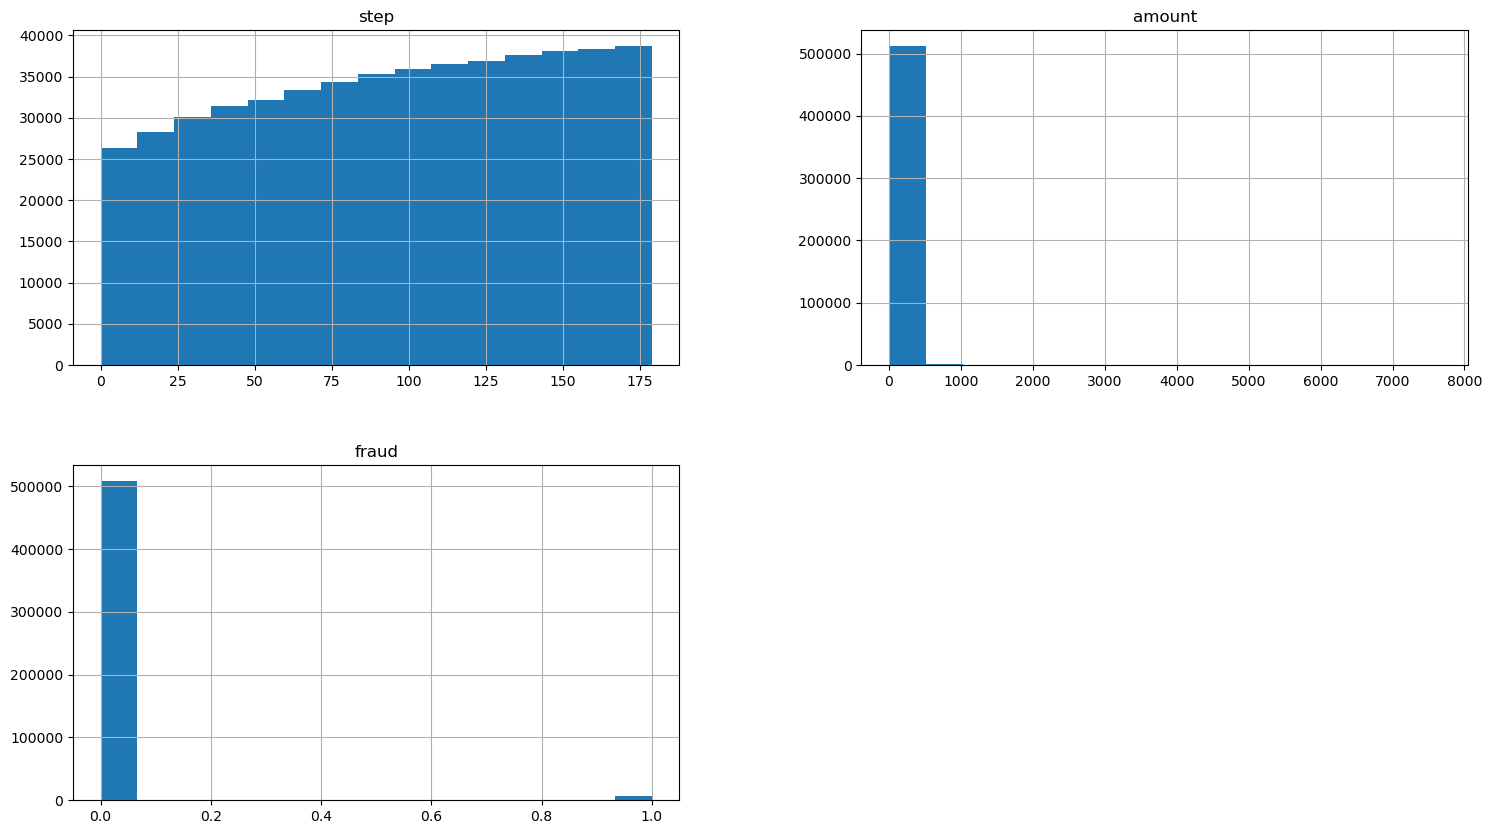

In [32]:
train[numerical_cols].hist(bins=15,figsize=(18, 10))

In [33]:
quantile_amounts = train.groupby('customer')['amount'].quantile(.95)

In [34]:
#For calculating larger amounts(Above 95 percent quantile)
def greater_quantile(row):
    quantile_amount = quantile_amounts[row['customer']]
    if row['amount'] > quantile_amount:
        return 1
    else:
        return 0

In [35]:
train['is_large_amount_quantile'] = train.apply(greater_quantile, axis=1)

In [36]:
train["is_large_amount_quantile"].value_counts()

is_large_amount_quantile
0    486150
1     27493
Name: count, dtype: int64

In [37]:
train["step"].nunique()

180

In [38]:
train.groupby("customer")["step"].mean()

customer
'C1000148617'    108.144144
'C100045114'     122.663158
'C1000699316'     50.784810
'C1001065306'     90.920000
'C1002658784'    105.422018
                    ...    
'C99729647'       89.321918
'C998690782'      89.564935
'C998987490'      89.634615
'C999393223'     107.089431
'C999723254'     110.231481
Name: step, Length: 4112, dtype: float64

### To Do:
one-hot-encode category and gender

Remove U and E rows

Outliers

Feature Selection

Correlation

Oversampling(SMOTE)

Scaling

In [39]:
train["gender"].value_counts()

gender
'F'    280199
'M'    231998
'E'      1009
'U'       437
Name: count, dtype: int64

In [40]:
train["age"].isnull().sum()

1009

In [41]:
train = train[~train['gender'].isin(["'U'", "'E'"])]

In [42]:
train.shape

(512197, 12)

In [43]:
df=train.copy()

In [44]:
df.drop(["zipcodeOri","zipMerchant"],axis=1,inplace=True)

In [45]:
df

,step,customer,age,gender,merchant,category,amount,fraud,number_of_transactions,is_large_amount_quantile
0,0,'C583110837',3.0,'M','M480139044','es_health',44.26,1,118,0
1,0,'C1332295774',3.0,'M','M480139044','es_health',324.50,1,43,0
2,0,'C1160421902',3.0,'M','M857378720','es_hotelservices',176.32,1,108,1
3,0,'C966214713',3.0,'M','M857378720','es_hotelservices',337.41,1,84,1
4,0,'C1450140987',4.0,'F','M1198415165','es_wellnessandbeauty',220.11,1,125,0
...,...,...,...,...,...,...,...,...,...,...
513638,179,'C748358246',2.0,'M','M1823072687','es_transportation',51.17,0,147,0
513639,179,'C1753498738',3.0,'F','M1823072687','es_transportation',20.53,0,159,0
513640,179,'C650108285',4.0,'F','M1823072687','es_transportation',50.73,0,146,0
513641,179,'C123623130',2.0,'F','M349281107','es_fashion',22.44,0,139,0


In [46]:
numerical_cols = [var for var in df.columns if df[var].dtype!='O']

<Axes: >

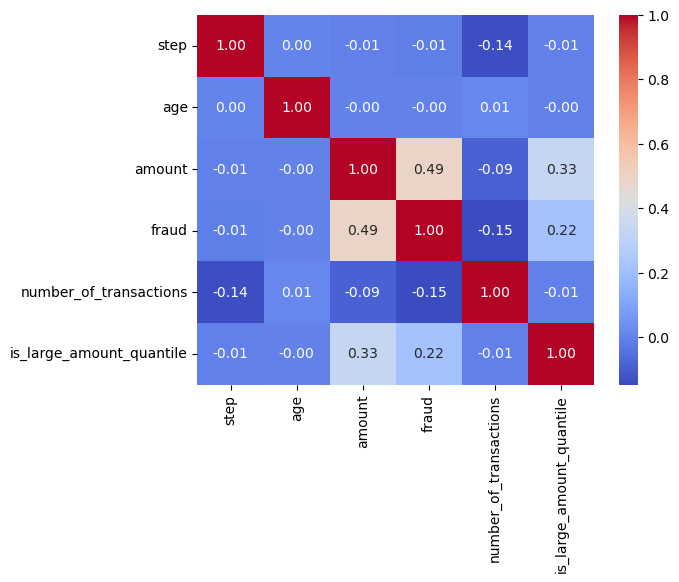

In [47]:
sns.heatmap(df[numerical_cols].corr(), cmap='coolwarm', annot=True, fmt='.2f')

In [48]:
corr_matrix = df[numerical_cols].corr()

In [49]:
fraud_corr = corr_matrix[['fraud']]

<Axes: >

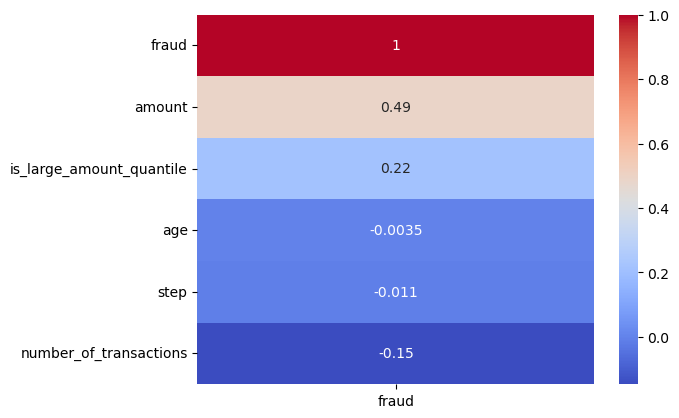

In [50]:
sns.heatmap(fraud_corr.sort_values(by='fraud', ascending=False), annot=True, cmap='coolwarm')

<Axes: ylabel='amount'>

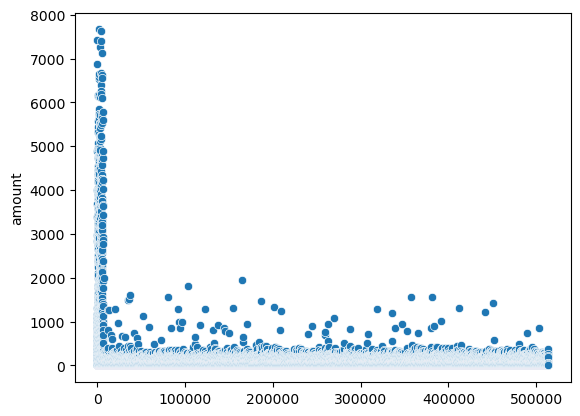

In [51]:
sns.scatterplot(df["amount"])

In [52]:
# IQR for outlier detection
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['amount'] < (Q1 - 1.5 * IQR)) | (df['amount'] > (Q3 + 1.5 * IQR))]

In [53]:
df["category"].value_counts()

category
'es_transportation'        435103
'es_food'                   22575
'es_health'                 13857
'es_wellnessandbeauty'      13016
'es_fashion'                 5551
'es_barsandrestaurants'      5535
'es_hyper'                   5271
'es_sportsandtoys'           3435
'es_tech'                    2011
'es_home'                    1711
'es_hotelservices'           1515
'es_otherservices'            800
'es_contents'                 761
'es_travel'                   625
'es_leisure'                  431
Name: count, dtype: int64

In [54]:
df.drop(["customer","merchant"],axis=1,inplace=True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 512197 entries, 0 to 513642
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   step                      512197 non-null  int64  
 1   age                       512197 non-null  float64
 2   gender                    512197 non-null  object 
 3   category                  512197 non-null  object 
 4   amount                    512197 non-null  float64
 5   fraud                     512197 non-null  int64  
 6   number_of_transactions    512197 non-null  int64  
 7   is_large_amount_quantile  512197 non-null  int64  
dtypes: float64(2), int64(4), object(2)
memory usage: 35.2+ MB


In [56]:
#Searching for Duplicated features
sel = DropConstantFeatures(tol=0.99, variables=None)

sel.fit(df)

features_to_drop = list(sel.features_to_drop_)
print(features_to_drop)

[]


In [57]:
#Looking for Correlated Features
sel = DropCorrelatedFeatures(threshold=0.80,    
                             method='pearson') 

sel.fit(df)

features_to_drop = features_to_drop + list(sel.features_to_drop_)
features_to_drop = list(set(features_to_drop))
print('Features to drop', sel.features_to_drop_)
print()
print('Correlated Feature Sets', sel.correlated_feature_sets_)

Features to drop []

Correlated Feature Sets []


In [58]:
X=df.drop("fraud",axis=1)
y=df["fraud"]

In [59]:
ss=StandardScaler()

In [60]:
numerical_col_names = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [61]:
temp=pd.DataFrame(ss.fit_transform(X[numerical_col_names]))

In [62]:
temp.reset_index(drop=True)

,0,1,2,3,4
0,-1.860102,-0.005903,0.056730,-0.719627,-0.237805
1,-1.860102,-0.005903,2.565980,-3.723042,-0.237805
2,-1.860102,-0.005903,1.239187,-1.120082,4.205127
3,-1.860102,-0.005903,2.681576,-2.081175,4.205127
4,-1.860102,0.748336,1.631279,-0.439308,-0.237805
...,...,...,...,...,...
512192,1.645138,-0.760143,0.118602,0.441694,-0.237805
512193,1.645138,-0.005903,-0.155747,0.922241,-0.237805
512194,1.645138,0.748336,0.114662,0.401649,-0.237805
512195,1.645138,-0.760143,-0.138645,0.121330,-0.237805


In [63]:
temp.columns=numerical_col_names

In [64]:
categorical_col_df = X.select_dtypes(exclude=['int64', 'float64'])

In [65]:
categorical_col_df.reset_index(drop=True)

,gender,category
0,'M','es_health'
1,'M','es_health'
2,'M','es_hotelservices'
3,'M','es_hotelservices'
4,'F','es_wellnessandbeauty'
...,...,...
512192,'M','es_transportation'
512193,'F','es_transportation'
512194,'F','es_transportation'
512195,'F','es_fashion'


In [66]:
temp.isnull().sum()

step                        0
age                         0
amount                      0
number_of_transactions      0
is_large_amount_quantile    0
dtype: int64

In [67]:
categorical_col_df.isnull().sum()

gender      0
category    0
dtype: int64

In [68]:
temp.index

RangeIndex(start=0, stop=512197, step=1)

In [69]:
categorical_col_df.index = temp.index

In [70]:
X=pd.concat([temp,categorical_col_df],axis=1)

In [71]:
X=pd.get_dummies(X)

In [72]:
# pca = PCA()
# X_pca = pca.fit_transform(X)
# print(pca.explained_variance_ratio_)


In [73]:
# import matplotlib.pyplot as plt

# cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
# plt.plot(cumulative_variance)
# plt.xlabel('Number of components')
# plt.ylabel('Cumulative explained variance')
# plt.show()


In [74]:
# pca = PCA(n_components=n_components)
# X = pca.fit_transform(X)

In [75]:
from sklearn.model_selection import train_test_split

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [77]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("After SMOTE, counts of label '1': {}".format(sum(y_train_smote == 1)))
print("After SMOTE, counts of label '0': {}".format(sum(y_train_smote == 0)))

After SMOTE, counts of label '1': 404789
After SMOTE, counts of label '0': 404789


In [78]:
import optuna
import xgboost as xgb

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 500)
    max_depth = trial.suggest_int('max_depth', 3, 8)
    clf = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth)
    return sklearn.model_selection.cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=3).mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)


[I 2024-08-21 17:38:25,035] A new study created in memory with name: no-name-8d111ad1-c3aa-43ed-b316-33ff69de44e0
[I 2024-08-21 17:38:30,500] Trial 0 finished with value: 0.995141022760877 and parameters: {'n_estimators': 199, 'max_depth': 8}. Best is trial 0 with value: 0.995141022760877.
[I 2024-08-21 17:38:37,153] Trial 1 finished with value: 0.9953777482632303 and parameters: {'n_estimators': 418, 'max_depth': 3}. Best is trial 1 with value: 0.9953777482632303.
[I 2024-08-21 17:38:54,417] Trial 2 finished with value: 0.9951117370038828 and parameters: {'n_estimators': 486, 'max_depth': 6}. Best is trial 1 with value: 0.9953777482632303.
[I 2024-08-21 17:39:07,315] Trial 3 finished with value: 0.9950604870095474 and parameters: {'n_estimators': 348, 'max_depth': 7}. Best is trial 1 with value: 0.9953777482632303.
[I 2024-08-21 17:39:17,184] Trial 4 finished with value: 0.9952191176185212 and parameters: {'n_estimators': 257, 'max_depth': 6}. Best is trial 1 with value: 0.99537774826

In [79]:
best_params = study.best_params
print(best_params)

{'n_estimators': 418, 'max_depth': 3}


In [80]:
best_trial = study.best_trial
print("Best trial value:", best_trial.value)

Best trial value: 0.9953777482632303


In [81]:
model = xgb.XGBClassifier(**best_params)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

In [82]:
probabilities = model.predict_proba(X_test)[:, 1]

In [96]:
threshold = 0.9
xgb_predictions = (probabilities >= threshold).astype(int)

In [102]:
precision_score(y_test, xgb_predictions)

0.9848714069591528

In [98]:
recall_score(y_test, xgb_predictions)

0.5309951060358891

In [99]:
f1_score(y_test, xgb_predictions)

0.6899841017488076

In [100]:
roc_auc_score(y_test, xgb_predictions)

0.765448152737351

<Axes: >

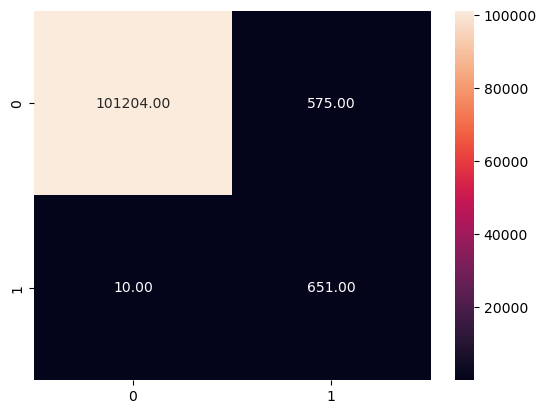

In [101]:
sns.heatmap(confusion_matrix(xgb_predictions,y_test),annot=True,fmt='.2f')

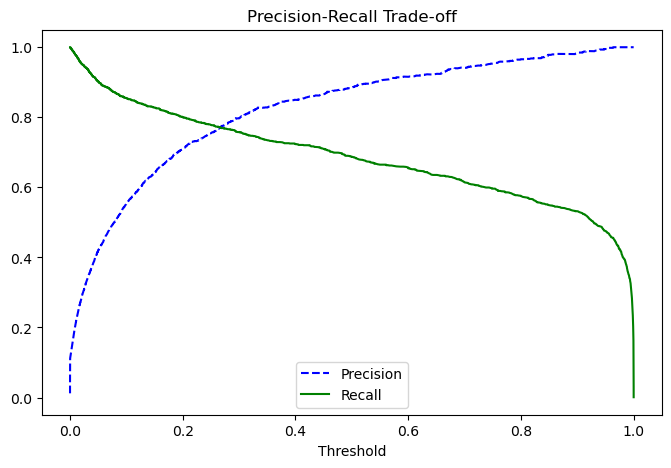

In [93]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precisions, recalls, thresholds = precision_recall_curve(y_test, probabilities)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision-Recall Trade-off")
plt.show()


In [ ]:
test=pd.read_csv(r"C:\Users\rohit\Downloads\test_hsbc_df.csv")

In [ ]:
#Converting age to numeric
test["age"]=test["age"].str.strip("'")

In [ ]:
test["age"] = test["age"].replace('U', np.nan)

In [ ]:
test["age"]=test["age"].astype(np.number)

In [ ]:
test.dropna(inplace=True)

In [ ]:
test['number_of_transactions'] =test.groupby('customer')['customer'].transform('count')

In [ ]:
quantile_amounts = test.groupby('customer')['amount'].quantile(.95)

In [1]:
#For calculating larger amounts(Above 95 percent quantile)
def greater_quantile(row):
    quantile_amount = quantile_amounts[row['customer']]
    if row['amount'] > quantile_amount:
        return 1
    else:
        return 0

In [ ]:
test['is_large_amount_quantile'] = test.apply(greater_quantile, axis=1)

In [ ]:
test = test[~test['gender'].isin(["'U'", "'E'"])]

In [ ]:
test.drop(["zipcodeOri","zipMerchant"],axis=1,inplace=True)

In [ ]:
test.drop(["customer","merchant"],axis=1,inplace=True)

In [ ]:
ss=StandardScaler()

In [ ]:
numerical_col_names = test.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [ ]:
temp=pd.DataFrame(ss.fit_transform(test[numerical_col_names]))

In [ ]:
temp.reset_index(drop=True)

In [ ]:
temp.columns=numerical_col_names

In [ ]:
categorical_col_df = test.select_dtypes(exclude=['int64', 'float64'])

In [ ]:
categorical_col_df.reset_index(drop=True)

In [ ]:
categorical_col_df.index = temp.index

In [ ]:
test=pd.concat([temp,categorical_col_df],axis=1)

In [ ]:
test=pd.get_dummies(X)